# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 42: Higher L-Moments OWA Portfolio Optimization

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].iloc[-300:,:].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-19,0.0475%,-0.8599%,-1.4332%,-3.0011%,0.1113%,1.2968%,3.4361%,-0.8763%,0.2945%,-0.7834%,...,0.6339%,-0.1823%,0.9186%,-0.7728%,1.1385%,-1.6075%,-1.1145%,-1.2872%,0.4575%,-0.8025%
2018-10-22,-1.9240%,-0.0786%,-0.6335%,-6.2983%,-0.6392%,-1.1024%,0.0527%,-0.3221%,1.1326%,-0.8199%,...,-0.8661%,0.4483%,-1.6953%,-2.8972%,-0.6085%,1.4753%,-0.6075%,-0.8634%,0.1457%,-3.4490%
2018-10-23,-3.6571%,-1.6658%,-0.4202%,-0.4521%,-0.2797%,-0.5034%,0.1845%,-3.9948%,-0.7051%,-0.2450%,...,0.4766%,-5.1240%,0.5341%,-0.0321%,1.0713%,-0.6728%,-1.0807%,-1.8308%,4.0560%,4.0353%
2018-10-24,-4.5500%,1.3141%,-1.8041%,-3.5933%,-4.2917%,0.8674%,0.9995%,-4.1109%,-3.6759%,-3.7139%,...,3.5178%,-4.2683%,1.5636%,-1.3479%,-8.0557%,-0.4838%,-1.2403%,-4.2187%,0.3671%,-3.3065%
2018-10-25,0.4741%,2.5716%,0.5186%,0.7782%,5.0410%,-0.5733%,-1.1719%,2.1585%,3.1657%,2.3270%,...,-1.0309%,0.4913%,0.5082%,0.9108%,-1.2516%,1.8962%,4.3661%,1.3799%,-1.7242%,3.3538%


## 2. Estimating Higher L-Moments OWA Portfolios

The OWA portfolio model proposed by __[Cajas (2021)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3988927)__ . This model gives an alternative formulation to risk measures that can be expressed using the OWA operator. The Higher L-Moments portfolio is a special case of the OWA portfolio where the weights are determined following  __[Cajas (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4393155)__.

It is recommended to use MOSEK to optimize OWA portfolios, due to it requires more computing power for the number of constraints and variables the model use.

Instructions to install MOSEK are in this __[link](https://docs.mosek.com/9.2/install/installation.html)__, is better to install using Anaconda. Also you will need a license, I recommend you that ask for an academic license __[here](https://www.mosek.com/products/academic-licenses/)__.

### 2.1 Calculating the portfolio that minimize a risk measure that includes Higher L-Moments

In [3]:
import riskfolio as rp
import mosek

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov,
                  d=0.94)

# Estimate optimal portfolios:

port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing GMD
port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

owa_w = rp.owa_l_moment_crm(len(Y), k=4)

w = port.owa_optimization(obj=obj,
                          owa_w=owa_w,
                          rf=rf,
                          l=l)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,3.8355%,0.0000%,3.1954%,4.5640%,9.3265%,2.7875%,0.0000%,0.0000%,7.0736%,...,13.2513%,0.0000%,19.9786%,3.7171%,3.3757%,0.0000%,0.0000%,0.0000%,15.6151%,0.0000%


### 2.2 Plotting portfolio composition

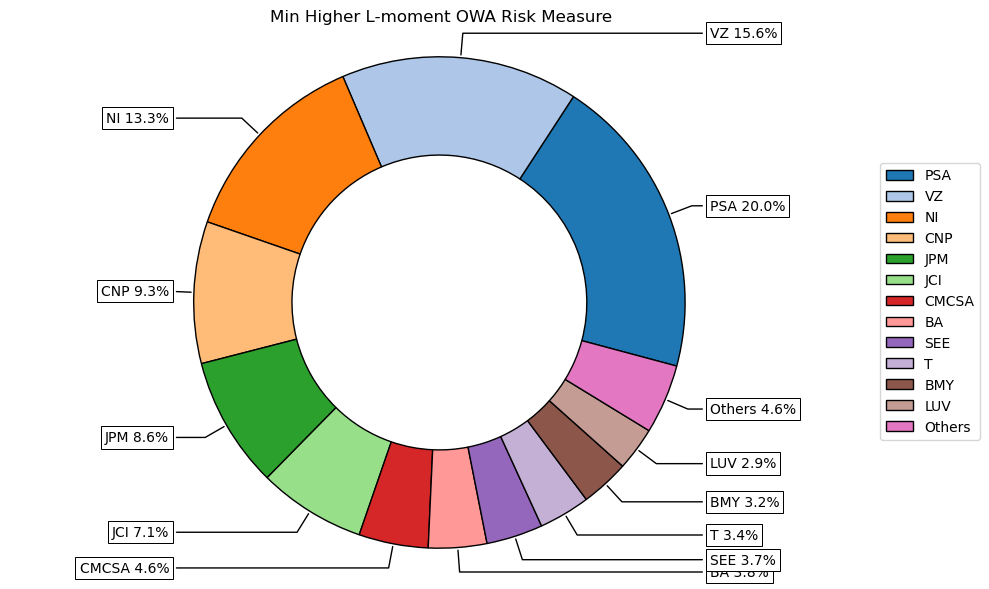

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='Min Higher L-moment OWA Risk Measure',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=10,
                 ax=None)